# Illustrative Example

In [1]:
import os
import numpy as np
import pandas as pd
from docplex.mp.advmodel import AdvModel as Model
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
mdl = Model(name='SCLCO_TautenhainCase')

## Input Data

In [6]:
PATH = os.getcwd()

In [7]:
time=2
ir=0.1
tr=0.3
beta=0.14971
data = pd.ExcelFile(os.path.join(PATH, 'SCLCO_Data.xlsx'))

In [9]:
A0 = pd.read_excel(data, 'A0', header=None).values.tolist()
A1 = pd.read_excel(data, 'A1_T', header=None).values.tolist()
Aprime = pd.read_excel(data, 'Aprime1_T', header=None).values.tolist()

Benv0= pd.read_excel(data, 'Benv0', header=None).values.tolist() 
Benv1= pd.read_excel(data, 'Benv1_T', header=None).values.tolist()
Benv1_2= pd.read_excel(data, 'Benv1_T2', header=None).values.tolist()
Becn01= pd.read_excel(data, 'Becn01', header=None).values.tolist()
Becn02= pd.read_excel(data, 'Becn02', header=None).values.tolist()
Becn1= pd.read_excel(data, 'Becn1_T', header=None).values.tolist()
becntruck= pd.read_excel(data, 'becntruck', header=None).values.tolist()
Bsoc0= pd.read_excel(data, 'Bsoc0', header=None).values.tolist()
Bsoc1= pd.read_excel(data, 'Bsoc1_T', header=None).values.tolist()

K= pd.read_excel(data, 'K', header=None).values.tolist()
f_t= pd.read_excel(data, 'f', header=None).transpose().values.tolist()
G= pd.read_excel(data, 'G', header=None).values.tolist()
e= pd.read_excel(data, 'e', header=None)[0].tolist()
er= pd.read_excel(data, 'er', header=None)[0].tolist()
R= pd.read_excel(data, 'R', header=None).values.tolist()

u0=pd.read_excel(data, 'u0', header=None)[0].transpose().values.tolist()
u1=pd.read_excel(data, 'u1_T', header=None)[0].transpose().values.tolist()
Lout0= pd.read_excel(data, 'Lout0', header=None).values.tolist()
Lout1= pd.read_excel(data, 'Lout1_T', header=None).values.tolist()
L1= pd.read_excel(data, 'L1_T', header=None).values.tolist()
Lprime= pd.read_excel(data, 'Lprime', header=None).values.tolist()

gama=pd.read_excel(data, 'gama', header=None).transpose().values.tolist()
sv=pd.read_excel(data, 'sv', header=None)[0].transpose().values.tolist()
prc= pd.read_excel(data, 'process', header=None)[0].values.tolist()
prd= pd.read_excel(data, 'product', header=None)[0].values.tolist()

In [12]:
A1_out = [[n if n > 0 else 0 for n in A1[i]] for i in range(0,len(A1))]
A0_out = [[n if n > 0 else 0 for n in A0[i]] for i in range(0,len(A0))]

In [13]:
process_tac=len(A1[0])
process_str=len(A0[0])
flow_tac=len(A1)
flow_str=len(A0)

In [8]:
print(process_tac, process_str, flow_tac, flow_str)

142 37 81 53


In [9]:
process_tac+process_str

179

In [10]:
process_tac_cont=92
process_tac_int=50
process_str_cont=3
process_str_int=34

## Data preprocessing 

In [11]:
def MatrixBuild (t_0, t_1T, timeperiod):
    WholeMatrix=[t_0]
    WholeMatrix.extend([t_1T for t in range (0,timeperiod)])
    return WholeMatrix

In [12]:
A= MatrixBuild(A0, A1, time)
Aout= MatrixBuild(A0_out, A1_out, time)
Benv= MatrixBuild(Benv0[0], Benv1[0],time)
Benv2= MatrixBuild(Benv0[0], Benv1_2[0], time)
becn= MatrixBuild([0 for i in range (0,process_str)], Becn1[0], time)
bsoc= MatrixBuild(Bsoc0[0], Bsoc1[0],time)
u=MatrixBuild(u0, u1, time)
Lout=MatrixBuild(Lout0, Lout1, time)
L=[L1 for t in range (0,time)]
Lprime=[Lprime for t in range (0,time)]
ft=[[0 for pstr in range(process_str)]]
ft.extend(f_t)

# Decision Variables

In [13]:
s=[]
s.extend(mdl.continuous_var_list(keys=process_str_cont, name='s'+str(0)))
s.extend(mdl.integer_var_list(keys=process_str_int, name='si'+str(0)))
for t in range(1,time+1):
    s.extend(mdl.continuous_var_list(keys=process_tac_cont, name='s'+str(t)))
    s.extend(mdl.integer_var_list(keys=process_tac_int, name='si'+str(t)))

In [14]:
st= [s[:process_str], s[process_str:process_str+process_tac], s[process_str+process_tac:]]

# Constraints

In [15]:
#SCLCO model
c8b=[mdl.matrix_constraints(np.diag(e).dot(A[t]), st[t], ((np.diag(e).dot(np.array(ft[t]))-(np.diag(e).dot(K).dot(A[t-1]).dot(st[t-1])))).tolist(), sense='eq') for t in range(2,time+1)]
c8c=[mdl.matrix_constraints(np.diag(np.subtract(1, e)).dot(A[t]), st[t], 
                            ((np.diag(np.subtract(1, e)).dot(ft[t])-(np.diag(np.subtract(1, e)).dot(K).dot(A[t-1]).dot(st[t-1])))).tolist(), sense='ge') for t in range(2,time+1)]
c8d=mdl.matrix_constraints(np.diag(e).dot(A[1]), st[1], (np.diag(e).dot(ft[1])).tolist(), sense='eq') 
c8e=mdl.matrix_constraints(np.diag(np.subtract(1, e)).dot(A[1]), st[1], (np.diag(np.subtract(1, e)).dot(ft[1])).tolist(), sense='ge')   
c8f=[mdl.matrix_constraints(Aprime,st[t], (-np.array(A[0]).dot(st[0])), sense='ge') for t in range(1,time+1)]
c8g=[mdl.matrix_constraints(Aout[t],st[t], u[t], sense='le') for t in range(0,time+1)]

#additional constraints for the case study of Tautenhain et al.(2021)
c14=mdl.matrix_constraints(G,st[0], [1,1], sense='le')
c15=[mdl.matrix_constraints(np.matmul(np.diag(er),A[t]).tolist(),st[t], (-beta*(np.array(R).dot(A[t-1]).dot(st[t-1]))).tolist(), sense='le') for t in range(2,time+1)]
c16=mdl.add_constraint(np.matmul(becntruck[0], st[0]) <= 670723)
c17=[mdl.matrix_constraints(Aout[t],st[t], (np.array(Lout[t]).dot(st[0])), sense='ge') for t in range(0,time+1)]
c18=[mdl.matrix_constraints(np.array(K).dot(A[t]),st[t], (np.array(L[t-1]).dot(st[0])), sense='ge') for t in range(1,time+1)]
c19=[mdl.matrix_constraints(Aprime,st[t], (-np.array(Lprime[t-1]).dot(st[0])).tolist(), sense='le') for t in range(1,time+1)]

In [16]:
for k in range(len(c8b)):
    for j in range(len(c8b[k])):
        mdl.add_constraint(c8b[k][j], ctname='c8b_'+str(k)+str(j))

In [17]:
for k in range(len(c8c)):
    for j in range(len(c8c[k])):
        mdl.add_constraint(c8c[k][j], ctname='c8c_'+str(k)+str(j))

In [18]:
for k in range(len(c8d)):
    mdl.add_constraint(c8d[k], ctname='c8d_'+str(k))

In [19]:
for k in range(len(c8e)):
    mdl.add_constraint(c8e[k], ctname='c8e_'+str(k))

In [20]:
for k in range(len(c8f)):
    for j in range(len(c8f[k])):
        mdl.add_constraint(c8f[k][j], ctname='c8f_'+str(k)+str(j))

In [21]:
for k in range(len(c8g)):
    for j in range(len(c8g[k])):
        mdl.add_constraint(c8g[k][j], ctname='c8g_'+str(k)+str(j))

In [22]:
for k in range(len(c14)):
    mdl.add_constraint(c14[k], ctname='c14_'+str(k))

In [23]:
for k in range(len(c15)):
    for j in range(len(c15[k])):
        mdl.add_constraint(c15[k][j], ctname='c15_'+str(k)+str(j))

In [24]:
for k in range(len(c17)):
    for j in range(len(c17[k])):
        mdl.add_constraint(c17[k][j], ctname='c17_'+str(k)+str(j))

In [25]:
for k in range(len(c18)):
    for j in range(len(c18[k])):
        mdl.add_constraint(c18[k][j], ctname='c18_'+str(k)+str(j))

In [26]:
for k in range(len(c19)):
    for j in range(len(c19[k])):
        mdl.add_constraint(c19[k][j], ctname='c19_'+str(k)+str(j))

In [27]:
mdl.print_information()

Model: SCLCO_TautenhainCase
 - number of variables: 321
   - binary=0, integer=134, continuous=187
 - number of constraints: 1212
   - linear=1212
 - parameters: defaults


# Solutions

## Auxilary functions

In [28]:
def ResultTable (ProcessList, NumTacProcess, NumStrProcess, ScalingVector, InterventionEnv, TacEcn, StrEcn1, StrEcn2, trate, irate, depr, salvage, InterventionSoc):
    #tactical decisions and their impacts
    DataTac=pd.DataFrame(columns=['Process name'])
    DataTac['Process name']= prc[0:NumTacProcess]
    DataTac['s1']= ScalingVector[1]
    DataTac['s2']= ScalingVector[2]
    DataTac['Env Impact']= np.diag(InterventionEnv[1]).dot(ScalingVector[1])+np.diag(InterventionEnv[2]).dot(ScalingVector[2]) 
    DataTac['CF1']= ((1-trate)*np.array(TacEcn[1]).dot(np.diag(ScalingVector[1])))/((1+irate)**1)
    DataTac['CF2']= (1-trate)*np.array(TacEcn[2]).dot(np.diag(ScalingVector[2]))/((1+irate)**2)
    DataTac['Ecn Impact']= DataTac['CF1']+DataTac['CF2']
    #DataTac['Ecn Impact']= np.diag(TacEcn[1]).dot(ScalingVector[1])+np.diag(TacEcn[2]).dot(ScalingVector[2])  
    DataTac['Soc Impact']= np.diag(InterventionSoc[1]).dot(ScalingVector[1])+np.diag(InterventionSoc[2]).dot(ScalingVector[2])  
    
    #strategic decisions and their impacts
    DataStr=pd.DataFrame(columns=['Process name'])
    DataStr['Process name']= prc[NumTacProcess:NumTacProcess+NumStrProcess+1]
    DataStr['s0']= ScalingVector[0]
    DataStr['Env Impact']= np.diag(InterventionEnv[0]).dot(ScalingVector[0])
    DataStr['CF1']= ((1-trate)*np.array(StrEcn1[0]).dot(np.diag(ScalingVector[0]))
                 -trate*np.matmul(np.array(StrEcn2[0]),np.matmul(np.diag(depr[t-1]),np.diag(ScalingVector[0]))))/((1+irate)**1)
    DataStr['CF2']= ((1-trate)*np.array(StrEcn1[0]).dot(np.diag(ScalingVector[0]))
                 -trate*np.matmul(np.array(StrEcn2[0]),np.matmul(np.diag(depr[t-1]),np.diag(ScalingVector[0])))
                 -(np.matmul(np.transpose(salvage), np.matmul(np.diag(StrEcn2[0]),np.diag(ScalingVector[0])))))/((1+irate)**2)
    DataStr['Ecn Impact']= DataStr['CF1']+DataStr['CF2']+np.array(StrEcn2[0]).dot(np.diag(ScalingVector[0])) 
    #DataStr['Ecn Impact']= np.diag(StrEcn1[0]).dot(ScalingVector[0]) + np.diag(StrEcn2[0]).dot(ScalingVector[0]) 
    DataStr['Soc Impact']= np.diag(InterventionSoc[0]).dot(ScalingVector[0])  

    #contribution analysis
    ResultTable = pd.merge(DataTac, DataStr , how="outer")
    ResultTable['Env Contribution']= (ResultTable['Env Impact'] / ResultTable['Env Impact'].sum(axis=0))*100;
    ResultTable['Ecn Contribution']= (ResultTable['Ecn Impact'] / ResultTable['Ecn Impact'][ResultTable['Ecn Impact'] > 0].sum(axis=0))*100;
    ResultTable['Soc Contribution']= (ResultTable['Soc Impact'] / ResultTable['Soc Impact'].sum(axis=0))*100;

    #s>0 filtering
    ResultTableFiltered= ResultTable[(ResultTable['s1'].astype(float) >= 0.0001) | (ResultTable['s2'].astype(float) >= 0.000011) | (ResultTable['s0'].astype(float) >= 0.00001)]
    ResultTableFiltered = ResultTableFiltered[['Process name','s0', 's1', 's2', 'Env Impact', 'Ecn Impact', 'Soc Impact','Env Contribution', 'Ecn Contribution','Soc Contribution']]
    ResultTableFiltered.fillna('-', inplace=True)
    return ResultTableFiltered

In [29]:
def Impacts(ScalingVector, InterventionMatrix, NumTimePeriod): 
    totalimpact=0
    for t in range(NumTimePeriod+1):
        totalimpact+=np.matmul(np.array(InterventionMatrix[t]),ScalingVector[t])  
    return totalimpact

## Solution for environmental objective

In [41]:
#objective function
totalenvimpact=0
for t in range(time+1):
    totalenvimpact+=mdl.sum(np.matmul(np.array(Benv[t]),st[t]))

In [42]:
mdl.minimize(totalenvimpact)
assert mdl.solve(), "Solve failed"
mdl.report()

* model SCLCO_TautenhainCase solved with objective = 394358.476


In [43]:
print(mdl.solve_details)
print("solve time =",mdl.solve_details.time)

status  = integer optimal solution
time    = 0.016 s.
problem = MILP
gap     = 0%

solve time = 0.015999999828636646


In [44]:
#solution
s_values = [s[t].solution_value for t in range(process_str+process_tac+process_tac)]
ScalingVectorEnv=[s_values[:process_str], s_values[process_str:process_str+process_tac], s_values[process_str+process_tac:]]
totalenvimpactEnv=mdl.objective_value

In [45]:
ResultTableEnv= ResultTable(prc, process_tac, process_str,ScalingVectorEnv,Benv,becn,Becn01,Becn02, tr, ir, gama, sv, bsoc)
NE=[0 for t in range (0,time+1)]
CF=[0 for t in range (0,time+1)]
DP=[0 for t in range (0,time+1)]
for t in range (1,time+1):
    DP[t]=np.matmul(np.array(Becn02),np.matmul(np.diag(gama[t-1]),ScalingVectorEnv[0]))
for t in range(1,time+1):
    NE[t]=(1-tr)*(np.matmul(np.array(becn[t]),ScalingVectorEnv[t])+np.matmul(np.array(Becn01),ScalingVectorEnv[0]))- tr*np.matmul(np.array(Becn02),np.matmul(np.diag(gama[t-1]),ScalingVectorEnv[0]))  
for t in range(1,time+1):
    if t<time:
        CF[t]=NE[t]
    else:
        CF[t]=NE[t]-(np.matmul(np.transpose(sv), np.matmul(np.diag(Becn02[0]),ScalingVectorEnv[0])))
NPVEnv=0
for t in range(1,time+1):
    NPVEnv+= (CF[t]/((1+ir)**t))
NPVEnv+=np.matmul(np.array(Becn02[0]),ScalingVectorEnv[0])
totalsocimpactEnv=Impacts(ScalingVectorEnv,bsoc,time)

## Solution for new environmental objective

In [46]:
#objective function
totalenvimpact=0
for t in range(time+1):
    totalenvimpact+=mdl.sum(np.matmul(np.array(Benv2[t]),st[t]))

In [47]:
mdl.minimize(totalenvimpact)
assert mdl.solve(), "Solve failed"
mdl.report()

* model SCLCO_TautenhainCase solved with objective = 397080.498


In [48]:
print(mdl.solve_details)
print("solve time =",mdl.solve_details.time)

status  = integer optimal solution
time    = 0.015 s.
problem = MILP
gap     = 0%

solve time = 0.014999999897554517


In [49]:
#solution
s_values = [s[t].solution_value for t in range(process_str+process_tac+process_tac)]
ScalingVectorEnv=[s_values[:process_str], s_values[process_str:process_str+process_tac], s_values[process_str+process_tac:]]
totalenvimpactEnv2=mdl.objective_value

In [50]:
ResultTableEnv2= ResultTable(prc, process_tac, process_str,ScalingVectorEnv,Benv2,becn,Becn01,Becn02, tr, ir, gama, sv, bsoc)
NE=[0 for t in range (0,time+1)]
CF=[0 for t in range (0,time+1)]
DP=[0 for t in range (0,time+1)]
for t in range (1,time+1):
    DP[t]=np.matmul(np.array(Becn02),np.matmul(np.diag(gama[t-1]),ScalingVectorEnv[0]))
for t in range(1,time+1):
    NE[t]=(1-tr)*(np.matmul(np.array(becn[t]),ScalingVectorEnv[t])+np.matmul(np.array(Becn01),ScalingVectorEnv[0]))- tr*np.matmul(np.array(Becn02),np.matmul(np.diag(gama[t-1]),ScalingVectorEnv[0]))  
for t in range(1,time+1):
    if t<time:
        CF[t]=NE[t]
    else:
        CF[t]=NE[t]-(np.matmul(np.transpose(sv), np.matmul(np.diag(Becn02[0]),ScalingVectorEnv[0])))
NPVEnv2=0
for t in range(1,time+1):
    NPVEnv2+= (CF[t]/((1+ir)**t))
NPVEnv2+=np.matmul(np.array(Becn02[0]),ScalingVectorEnv[0])
totalsocimpactEnv2=Impacts(ScalingVectorEnv,bsoc,time)

## Solution for economic objective

In [51]:
#objective function
NE=[0 for t in range (0,time+1)]
CF=[0 for t in range (0,time+1)]
DP=[0 for t in range (0,time+1)]
for t in range (1,time+1):
    DP[t]=mdl.sum(np.matmul(np.array(Becn02),np.matmul(np.diag(gama[t-1]),st[0])))
for t in range(1,time+1):
    NE[t]=(1-tr)*(mdl.sum(np.matmul(np.array(becn[t]),st[t]))+mdl.sum(np.matmul(np.array(Becn01),st[0])))- tr*mdl.sum(np.matmul(np.array(Becn02),np.matmul(np.diag(gama[t-1]),st[0])))
for t in range(1,time+1):
    if t<time:
        CF[t]=NE[t]
    else:
        CF[t]=NE[t]-(mdl.sum(np.matmul(np.transpose(sv), np.matmul(np.diag(Becn02[0]),st[0]))))
NPV=0
for t in range(1,time+1):
    NPV+= (CF[t]/((1+ir)**t))
NPV+=mdl.sum(np.matmul(np.array(Becn02[0]),st[0]))

In [52]:
mdl.minimize(NPV)
assert mdl.solve(), "Solve failed"
mdl.report()

* model SCLCO_TautenhainCase solved with objective = -709190.912


In [53]:
print(mdl.solve_details)
print("solve time =",mdl.solve_details.time)

status  = integer optimal, tolerance
time    = 0.359 s.
problem = MILP
gap     = 0.0074139%

solve time = 0.35900000017136335


In [54]:
#solution
s_values = [s[t].solution_value for t in range(process_str+process_tac+process_tac)]
ScalingVectorEcn=[s_values[:process_str], s_values[process_str:process_str+process_tac], s_values[process_str+process_tac:]]
NPVEcn=mdl.objective_value

In [55]:
ResultTableEcn= ResultTable(prc, process_tac, process_str,ScalingVectorEcn,Benv,becn,Becn01,Becn02,tr, ir, gama, sv,bsoc)
totalenvimpactEcn=Impacts(ScalingVectorEcn,Benv, time)
totalenvimpactEcn2=Impacts(ScalingVectorEcn,Benv2, time)
totalsocimpactEcn=Impacts(ScalingVectorEcn,bsoc, time)

## Solution for social objective

In [56]:
#objective function
totalsocimpact=0
for t in range(time+1):
    totalsocimpact+=mdl.sum(np.matmul(np.array(bsoc[t]),st[t]))

In [57]:
mdl.minimize(totalsocimpact)
assert mdl.solve(), "Solve failed"
mdl.report()

* model SCLCO_TautenhainCase solved with objective = -501.266


In [58]:
print(mdl.solve_details)
print("solve time =",mdl.solve_details.time)

status  = integer optimal, tolerance
time    = 0.156 s.
problem = MILP
gap     = 0.00370883%

solve time = 0.1559999999590218


In [59]:
#solution
s_values = [s[t].solution_value for t in range(process_str+process_tac+process_tac)]
ScalingVectorSoc=[s_values[:process_str], s_values[process_str:process_str+process_tac], s_values[process_str+process_tac:]]
totalsocimpactSoc=mdl.objective_value

In [60]:
ResultTableSoc= ResultTable(prc, process_tac, process_str,ScalingVectorSoc,Benv,becn,Becn01,Becn02,tr, ir, gama, sv,bsoc)
NE=[0 for t in range (0,time+1)]
CF=[0 for t in range (0,time+1)]
DP=[0 for t in range (0,time+1)]
for t in range (1,time+1):
    DP[t]=np.matmul(np.array(Becn02),np.matmul(np.diag(gama[t-1]),ScalingVectorSoc[0]))
for t in range(1,time+1):
    NE[t]=(1-tr)*(np.matmul(np.array(becn[t]),ScalingVectorSoc[t])+np.matmul(np.array(Becn01),ScalingVectorSoc[0]))- tr*np.matmul(np.array(Becn02),np.matmul(np.diag(gama[t-1]),ScalingVectorSoc[0]))  
for t in range(1,time+1):
    if t<time:
        CF[t]=NE[t]
    else:
        CF[t]=NE[t]-(np.matmul(np.transpose(sv), np.matmul(np.diag(Becn02[0]),ScalingVectorSoc[0])))
NPVSoc=0
for t in range(1,time+1):
    NPVSoc+= (CF[t]/((1+ir)**t))
NPVSoc+=np.matmul(np.array(Becn02[0]),ScalingVectorSoc[0])
totalenvimpactSoc=Impacts(ScalingVectorSoc,Benv, time)
totalenvimpactSoc2=Impacts(ScalingVectorSoc,Benv2, time)

# Results

In [61]:
AllResults=[[totalenvimpactEnv, NPVEnv[0],totalsocimpactEnv],[totalenvimpactEcn, NPVEcn,totalsocimpactEcn], [totalenvimpactSoc, NPVSoc[0],totalsocimpactSoc]]

In [62]:
WTable=pd.DataFrame(AllResults, index=['min Wenv', 'min Wecn', 'min Wsoc'], columns=['Wenv', 'Wecn', 'Wsoc'])

In [63]:
WTable

,Wenv,Wecn,Wsoc
min Wenv,394358.476,1343890.013,-11.985
min Wecn,620113.171,-709190.912,-11.719
min Wsoc,461992.414,255309045.195,-501.266


In [64]:
AllResults2=[[totalenvimpactEnv2, NPVEnv2[0],totalsocimpactEnv2],[totalenvimpactEcn2, NPVEcn,totalsocimpactEcn], [totalenvimpactSoc2, NPVSoc[0],totalsocimpactSoc]]

In [65]:
WTable2=pd.DataFrame(AllResults2, index=['min Wenv', 'min Wecn', 'min Wsoc'], columns=['Wenv', 'Wecn', 'Wsoc'])

In [67]:
WTable2-WTable

,Wenv,Wecn,Wsoc
min Wenv,2722.022,285551.314,-0.044
min Wecn,1294.676,0.000,0.000
min Wsoc,2061.071,0.000,0.000


In [264]:
np.log1p(-1*WTable['Wsoc'])

min Wenv   2.564
min Wecn   2.543
min Wsoc   6.219
Name: Wsoc, dtype: float64

In [72]:
ResultTableEnv

,Process name,s0,s1,s2,Env Impact,Ecn Impact,Soc Impact,Env Contribution,Ecn Contribution,Soc Contribution
0,RM1 production,-,9272.000,4497.847,128890.781,1853.528,0.000,32.682,0.047,-0.000
1,RM2 production,-,1660.500,805.509,23082.737,278.483,0.000,5.853,0.007,-0.000
5,FP production with TCH1 using T2,-,50000.000,24255.000,222249.919,16663.724,0.000,56.354,0.424,-0.000
8,FP arrival & storage at FW,-,5715.000,0.000,0.000,930.625,0.000,0.000,0.024,-0.000
9,FP storage at FW,-,0.000,5715.000,0.000,846.023,0.000,0.000,0.022,-0.000
14,FP handling at SEA1 using T2 from F,-,30220.000,23061.000,0.001,4425.816,0.000,0.000,0.113,-0.000
25,FP Handling at SEA2 using SHP,-,30220.000,23061.000,0.001,0.000,0.000,0.000,0.000,-0.000
35,Usage at C2 using T2 from SEA2,-,30220.000,23061.000,0.001,-1518053.445,0.000,0.000,-38.589,-0.000
39,Usage at C1 using T2 from F,-,14065.000,10051.000,0.000,-688143.066,0.000,0.000,-17.493,-0.000
43,Usage at C1 using T2 from FW,-,0.000,5715.000,0.000,-154089.044,0.000,0.000,-3.917,-0.000


In [269]:
ResultTableEcn

,Process name,s0,s1,s2,Env Impact,Ecn Impact,Soc Impact,Env Contribution,Ecn Contribution,Soc Contribution
0,RM1 production,-,13045.826,10097.164,216626.805,3083.223,0.000,34.933,0.186,-0.000
1,RM2 production,-,8513.880,6589.544,141373.545,1688.085,0.000,22.798,0.102,-0.000
3,FP production with TCH2 using T1,-,46103.212,35682.806,258786.873,12563.813,0.000,41.732,0.759,-0.000
8,FP storage at FW,-,32038.212,21242.788,0.001,8361.761,0.000,0.000,0.505,-0.000
9,On-hand FP stock storage at FW,-,0.000,1818.212,0.000,269.160,0.000,0.000,0.016,-0.000
16,FP handling at SEA1 using T2 from FW,-,30220.000,23061.000,0.001,-3909.029,0.000,0.000,-0.236,-0.000
25,FP Handling at SEA2 using SHP,-,30220.000,23061.000,0.001,0.000,0.000,0.000,0.000,-0.000
34,Usage at C2 using T1 from SEA2,-,30220.000,23061.000,0.001,-1518053.445,0.000,0.000,-91.725,-0.000
39,Usage at C1 using T2 from F,-,14065.000,15766.000,0.000,-842232.110,0.000,0.000,-50.890,-0.000
54,RFP Handling at SEA2 using T1 from C2,-,0.000,4524.236,0.000,22816.531,0.000,0.000,1.379,-0.000


In [270]:
ResultTableSoc

,Process name,s0,s1,s2,Env Impact,Ecn Impact,Soc Impact,Env Contribution,Ecn Contribution,Soc Contribution
0,RM1 production,-,12621.603,2845.737,144779.932,2109.853,0.000,31.338,0.001,-0.000
1,RM2 production,-,2260.372,509.636,25928.287,316.994,0.000,5.612,0.000,-0.000
2,FP production with TCH1 using T1,-,68063.000,15345.866,249648.019,18968.149,0.000,54.037,0.007,-0.000
10,FP storage at W1 using T1,-,3577.980,1.000,0.000,582.783,0.000,0.000,0.000,-0.000
12,On-hand FP stock storage at W1,-,0.000,3576.980,0.000,529.520,0.000,0.000,0.000,-0.000
19,FP handling at AIR1 using T1 from F,-,50420.020,0.000,0.001,4635.694,0.000,0.000,0.002,-0.000
23,FP Handling at AIR1 using T1 from W1,-,1.000,3243.980,0.000,271.234,0.000,0.000,0.000,-0.000
26,FP Handling at AIR2 using PLN,-,50421.020,3243.980,0.001,0.000,0.000,0.000,0.000,-0.000
29,FP Storage at W2 using T1 from AIR2,-,20202.020,3243.980,0.000,3769.903,0.000,0.000,0.001,-0.000
31,On-hand FP stock storage at W2,-,0.000,20201.020,0.000,2990.469,0.000,0.000,0.001,-0.000


In [215]:
ResultTableEnv['Env Cont']= ResultTableEnv['Env Impact']/totalenvimpactEnv*100
ResultTableEnv['Ecn Cont']= ResultTableEnv['Ecn Impact']/-NPVEcn*100
ResultTableEnv['Soc Cont']= ResultTableEnv['Soc Impact']/-totalsocimpactSoc*100

In [193]:
sorted_Env1 = ResultTableEcn[['Process name','Env Cont']].sort_values('Env Cont',ascending=False)
ContEnv1=sorted_Env1.iloc[:3]
ContEnv1.loc[len(d.index)]=['rest',  sorted_Env1['Env Cont'].iloc[3:].sum()]

C:\Users\shu223\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [195]:
sorted_Env2 = ResultTableEcn[['Process name','Env Cont']].sort_values('Env Cont',ascending=False)
ContEnv2=sorted_Env2.iloc[:3]
ContEnv2.loc[len(d.index)]=['rest',  sorted_Env2['Env Cont'].iloc[3:].sum()]

C:\Users\shu223\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [196]:
ContEnv2

,Process name,Env Cont
3,FP production with TCH2 using T1,65.622
0,RM1 production,54.931
1,RM2 production,35.849
4,rest,0.843


In [203]:
ContEnv01 = pd.merge(ContEnv0, ContEnv1, how="inner")
ContEnv =pd.merge(ContEnv01, ContEnv2, how="inner")

In [204]:
ContEnv

,Process name,Env Cont


In [110]:
ResultTableEnv

,Process name,s0,s1,s2,Env Impact,Ecn Impact,Soc Impact,Env Cont,Ecn Cont,Soc Cont
0,RM1 production,-,13585.580,184.267,128890.781,1907.929,0.000,32.684,0.269,0.000
1,RM2 production,-,2433.009,33.000,23082.737,286.656,0.000,5.853,0.040,0.000
5,FP production with TCH1 using T2,-,73261.323,993.677,222249.919,17152.804,0.000,56.357,2.419,0.000
8,FP storage at FW,-,28976.323,0.000,0.000,4718.478,0.000,0.000,0.665,0.000
9,On-hand FP stock storage at FW,-,0.000,28976.323,0.000,4289.526,0.000,0.000,0.605,0.000
14,FP handling at SEA1 using T2 from F,-,30220.000,0.000,0.000,2613.057,0.000,0.000,0.368,0.000
16,FP handling at SEA1 using T2 from FW,-,0.000,23061.000,0.000,-1601.089,0.000,0.000,-0.226,0.000
25,FP Handling at SEA2 using SHP,-,30220.000,23061.000,0.001,0.000,0.000,0.000,0.000,0.000
35,Usage at C2 using T2 from SEA2,-,30220.000,23061.000,0.001,-1518053.445,0.000,0.000,-214.054,0.000
39,Usage at C1 using T2 from F,-,14065.000,9850.677,0.000,-682741.904,0.000,0.000,-96.271,0.000


In [266]:
ResultTableEcn

,Process name,s0,s1,s2,Env Impact,Ecn Impact,Soc Impact,Env Contribution,Ecn Contribution,Soc Contribution
0,RM1 production,-,13045.826,10097.164,216626.805,3083.223,0.000,34.933,0.186,-0.000
1,RM2 production,-,8513.880,6589.544,141373.545,1688.085,0.000,22.798,0.102,-0.000
3,FP production with TCH2 using T1,-,46103.212,35682.806,258786.873,12563.813,0.000,41.732,0.759,-0.000
8,FP storage at FW,-,32038.212,21242.788,0.001,8361.761,0.000,0.000,0.505,-0.000
9,On-hand FP stock storage at FW,-,0.000,1818.212,0.000,269.160,0.000,0.000,0.016,-0.000
16,FP handling at SEA1 using T2 from FW,-,30220.000,23061.000,0.001,-3909.029,0.000,0.000,-0.236,-0.000
25,FP Handling at SEA2 using SHP,-,30220.000,23061.000,0.001,0.000,0.000,0.000,0.000,-0.000
34,Usage at C2 using T1 from SEA2,-,30220.000,23061.000,0.001,-1518053.445,0.000,0.000,-91.725,-0.000
39,Usage at C1 using T2 from F,-,14065.000,15766.000,0.000,-842232.110,0.000,0.000,-50.890,-0.000
54,RFP Handling at SEA2 using T1 from C2,-,0.000,4524.236,0.000,22816.531,0.000,0.000,1.379,-0.000


In [267]:
ResultTableSoc

,Process name,s0,s1,s2,Env Impact,Ecn Impact,Soc Impact,Env Contribution,Ecn Contribution,Soc Contribution
0,RM1 production,-,12621.603,2845.737,144779.932,2109.853,0.000,31.338,0.001,-0.000
1,RM2 production,-,2260.372,509.636,25928.287,316.994,0.000,5.612,0.000,-0.000
2,FP production with TCH1 using T1,-,68063.000,15345.866,249648.019,18968.149,0.000,54.037,0.007,-0.000
10,FP storage at W1 using T1,-,3577.980,1.000,0.000,582.783,0.000,0.000,0.000,-0.000
12,On-hand FP stock storage at W1,-,0.000,3576.980,0.000,529.520,0.000,0.000,0.000,-0.000
19,FP handling at AIR1 using T1 from F,-,50420.020,0.000,0.001,4635.694,0.000,0.000,0.002,-0.000
23,FP Handling at AIR1 using T1 from W1,-,1.000,3243.980,0.000,271.234,0.000,0.000,0.000,-0.000
26,FP Handling at AIR2 using PLN,-,50421.020,3243.980,0.001,0.000,0.000,0.000,0.000,-0.000
29,FP Storage at W2 using T1 from AIR2,-,20202.020,3243.980,0.000,3769.903,0.000,0.000,0.001,-0.000
31,On-hand FP stock storage at W2,-,0.000,20201.020,0.000,2990.469,0.000,0.000,0.001,-0.000


In [111]:
ResultTableEcn['Env Cont']= ResultTableEcn['Env Impact']/totalenvimpactEnv*100
ResultTableEcn['Ecn Cont']= ResultTableEcn['Ecn Impact']/-NPVEcn*100
ResultTableEcn['Soc Cont']= ResultTableEcn['Soc Impact']/-totalsocimpactSoc*100

In [112]:
ResultTableEcn

,Process name,s0,s1,s2,Env Impact,Ecn Impact,Soc Impact,Env Cont,Ecn Cont,Soc Cont
0,RM1 production,-,13045.826,10097.164,216626.805,3083.223,0.000,54.931,0.435,0.000
1,RM2 production,-,8513.880,6589.544,141373.545,1688.085,0.000,35.849,0.238,0.000
3,FP production with TCH2 using T1,-,46103.212,35682.806,258786.873,12563.813,0.000,65.622,1.772,0.000
8,FP storage at FW,-,32038.212,21242.788,0.001,8361.761,0.000,0.000,1.179,0.000
9,On-hand FP stock storage at FW,-,0.000,1818.212,0.000,269.160,0.000,0.000,0.038,0.000
16,FP handling at SEA1 using T2 from FW,-,30220.000,23061.000,0.001,-3909.029,0.000,0.000,-0.551,0.000
25,FP Handling at SEA2 using SHP,-,30220.000,23061.000,0.001,0.000,0.000,0.000,0.000,0.000
34,Usage at C2 using T1 from SEA2,-,30220.000,23061.000,0.001,-1518053.445,0.000,0.000,-214.054,0.000
39,Usage at C1 using T2 from F,-,14065.000,15766.000,0.000,-842232.110,0.000,0.000,-118.760,0.000
54,RFP Handling at SEA2 using T1 from C2,-,0.000,4524.236,0.000,22816.531,0.000,0.000,3.217,0.000


In [113]:
ResultTableSoc['Env Cont']= ResultTableSoc['Env Impact']/totalenvimpactEnv*100
ResultTableSoc['Ecn Cont']= ResultTableSoc['Ecn Impact']/-NPVEcn*100
ResultTableSoc['Soc Cont']= ResultTableSoc['Soc Impact']/-totalsocimpactSoc*100

In [114]:
ResultTableSoc

,Process name,s0,s1,s2,Env Impact,Ecn Impact,Soc Impact,Env Cont,Ecn Cont,Soc Cont
0,RM1 production,-,12621.603,2845.737,144779.932,2109.853,0.000,36.713,0.298,0.000
1,RM2 production,-,2260.372,509.636,25928.287,316.994,0.000,6.575,0.045,0.000
2,FP production with TCH1 using T1,-,68063.000,15345.866,249648.019,18968.149,0.000,63.305,2.675,0.000
10,FP storage at W1 using T1,-,3577.980,1.000,0.000,582.783,0.000,0.000,0.082,0.000
12,On-hand FP stock storage at W1,-,0.000,3576.980,0.000,529.520,0.000,0.000,0.075,0.000
19,FP handling at AIR1 using T1 from F,-,50420.020,0.000,0.001,4635.694,0.000,0.000,0.654,0.000
23,FP Handling at AIR1 using T1 from W1,-,1.000,3243.980,0.000,271.234,0.000,0.000,0.038,0.000
26,FP Handling at AIR2 using PLN,-,50421.020,3243.980,0.001,0.000,0.000,0.000,0.000,0.000
29,FP Storage at W2 using T1 from AIR2,-,20202.020,3243.980,0.000,3769.903,0.000,0.000,0.532,0.000
31,On-hand FP stock storage at W2,-,0.000,20201.020,0.000,2990.469,0.000,0.000,0.422,0.000


In [55]:
ResultTableSoc['Soc Contribution'][ResultTableSoc['Soc Contribution'] >= 5]

142    6.595
143    5.192
159   81.392
Name: Soc Contribution, dtype: float64

In [63]:
(ResultTableEcn['Soc Contribution'][ResultTableEcn['Soc Contribution'] >= 5])#/totalsocimpactSoc)*totalsocimpactEcn

159   16.422
161   10.249
166   25.607
169   25.607
172    5.121
Name: Soc Contribution, dtype: float64

In [74]:
np.array((ResultTableEnv['Soc Contribution'][ResultTableEnv['Soc Contribution'] >= 5]/totalsocimpactSoc)*totalsocimpactEcn).sum()

1.8976266731478197

In [72]:
11/500

0.022

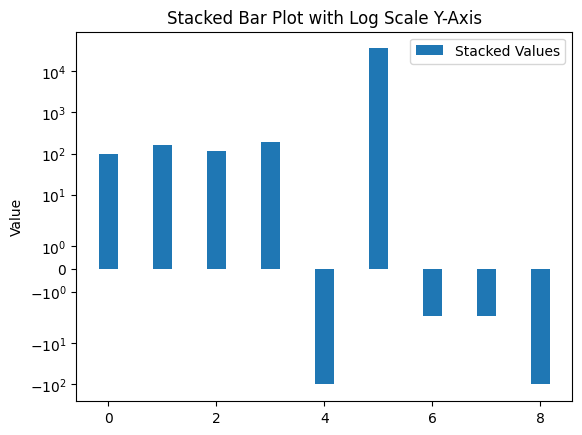

In [101]:
import numpy as np
import matplotlib.pyplot as plt

# Stacked values

sum_first0 = 394358.476/3943.58476
sum_second0 = 620113.171/3943.58476
sum_third0 = 461992.414/3943.58476


# Calculating the sums for each stacked bar
sum_first = 1343890.013/7091.90912
sum_second = -709190.912/7091.90912
sum_third = 255309045.195/7091.90912

sum_first1 = -11/5
sum_second1 = -11/5
sum_third1 = -500/5

# Creating positions for the bars
ind = np.arange(9)  # the x locations for the groups

# Plotting the bars
p1 = plt.bar(ind, [sum_first0, sum_second0, sum_third0, sum_first, sum_second, sum_third, sum_first1, sum_second1, sum_third1], 0.35, label='Stacked Values')

# Setting the labels and title
plt.ylabel('Value')
plt.title('Stacked Bar Plot with Log Scale Y-Axis')
#plt.xticks(ind, ('First', 'Second', 'Third'))

# Setting the y-axis to logarithmic scale
plt.yscale('symlog')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
NE=[0 for t in range (0,time+1)]
CF=[0 for t in range (0,time+1)]
DP=[0 for t in range (0,time+1)]
for t in range (1,time+1):
    DP[t]=np.matmul(np.array(Becn02),np.matmul(np.diag(gama[t-1]),ScalingVectorEnv[0]))
for t in range(1,time+1):
    NE[t]=(1-tr)*(np.matmul(np.array(becn[t]),ScalingVectorEnv[t])+np.matmul(np.array(Becn01),ScalingVectorEnv[0]))- tr*np.matmul(np.array(Becn02),np.matmul(np.diag(gama[t-1]),ScalingVectorEnv[0]))  
for t in range(1,time+1):
    if t<time:
        CF[t]=NE[t]
    else:
        CF[t]=NE[t]-(np.matmul(np.transpose(sv), np.matmul(np.diag(Becn02[0]),ScalingVectorEnv[0])))
NPVEnv=0
for t in range(1,time+1):
    NPVEnv+= (CF[t]/((1+ir)**t))
NPVEnv+=np.matmul(np.array(Becn02[0]),ScalingVectorEnv[0])

DataTac=pd.DataFrame(columns=['Process name'])
DataTac['Process name']= prc[0:142]
DataTac['s1']= ScalingVectorEcn[1]
DataTac['s2']= ScalingVectorEcn[2] 
DataTac['CF1']= ((1-tr)*np.array(becn[1]).dot(np.diag(ScalingVectorEcn[1])))/((1+ir)**1)
DataTac['CF2']= (1-tr)*np.array(becn[2]).dot(np.diag(ScalingVectorEcn[2]))/((1+ir)**2)
DataTac['EcnImpact']= DataTac['NE1']+DataTac['CF2']

#strategic decisions and their impacts
DataStr=pd.DataFrame(columns=['Process name'])
DataStr['Process name']= prc[142:179]
DataStr['s0']= ScalingVectorEcn[0]
DataStr['CF1']= ((1-tr)*np.array(Becn01[0]).dot(np.diag(ScalingVectorEcn[0]))
                 -tr*np.matmul(np.array(Becn02[0]),np.matmul(np.diag(gama[t-1]),np.diag(ScalingVectorEcn[0]))))/((1+ir)**1)
DataStr['CF2']= ((1-tr)*np.array(Becn01[0]).dot(np.diag(ScalingVectorEcn[0]))
                 -tr*np.matmul(np.array(Becn02[0]),np.matmul(np.diag(gama[t-1]),np.diag(ScalingVectorEcn[0])))
                 -(np.matmul(np.transpose(sv), np.matmul(np.diag(Becn02[0]),np.diag(ScalingVectorEcn[0])))))/((1+ir)**2)

DataStr['EcnImpact']= DataStr['NE1']+DataStr['CF2']+np.array(Becn02[0]).dot(np.diag(ScalingVectorEcn[0])) 

#contribution analysis
ResultTable = pd.merge(DataTac, DataStr , how="outer")

#s>0 filtering
ResultTableFiltered= ResultTable[(ResultTable['s1'].astype(float) >= 0.0001) | (ResultTable['s2'].astype(float) >= 0.000011) | (ResultTable['s0'].astype(float) >= 0.00001)]
ResultTableFiltered = ResultTableFiltered[['Process name','s0', 's1', 's2', 'NE1', 'CF2', 'Overall']]
ResultTableFiltered.fillna('-', inplace=True)

# Export

In [125]:
ResultTableEnv.to_csv("C:\\Users\\shu223\\Desktop\\Researches\\LCO\\IllustrativeExample\\ResultEnv_EJOR.csv")

In [126]:
ResultTableEcn.to_csv("C:\\Users\\shu223\\Desktop\\Researches\\LCO\\IllustrativeExample\\ResultEcn_EJOR.csv")

In [127]:
ResultTableSoc.to_csv("C:\\Users\\shu223\\Desktop\\Researches\\LCO\\IllustrativeExample\\ResultSoc_EJOR.csv")